# Plot K-shot learning figures

In [12]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib


In [13]:
results_dir = "/home/hossein/ssl-wearables/data/reports/notable_results_Kshot_MLP.csv"
selected_model = "MLP" #"RESNET" # "MLP"
results = pd.read_csv(results_dir)
results = results[results["model"]==selected_model]
results = results.sort_values(by=["plot_legend", "split"])
print(results.columns)
print(results["plot_legend"].unique())   

Index(['path', 'trained_dataset', 'evaluated_dataset', 'train_map_path',
       'validation', 'split', 'plot_legend', 'conditions', 'comments',
       'freeze_weight', 'model'],
      dtype='object')
['Broader -> OPT' 'Broader -> OPT -> Personalized'
 'Broader -> Personlized']


In [14]:
def aggregate_metrics(df, metrics):
    """
    Aggregate the metrics by calculating the mean and standard deviation of the given metric.
    """
    results = pd.DataFrame()
    for metric in metrics:
        # print(f"Aggregating metric: {metric}")
        df1=aggregate_metric(df, metric)
        df1.reset_index(drop=True, inplace=True)
        # print(df1)
        #concatenate the new DataFrame with the original DataFrame
        results = pd.concat([results, df1], axis=1)
        # results = results.join(df1)
        # print(results)
        # df = df.join(aggregate_metric(df, metric))
    # print(results)
    return results
def aggregate_metric(df, metric):
    """
    Aggregate a single metric by calculating the mean and standard deviation.
    """
    # Check if the metric exists in the DataFrame
    if metric not in df.columns:
        raise ValueError(f"Metric '{metric}' not found in DataFrame columns.")
    # Group by conditions and split, and calculate mean and std
    # for the given metric
    result = df[metric].agg(['mean', 'std']).to_frame().T
    result.columns = [f'{metric}_mean', f'{metric}_std']
    return result


In [15]:
import re

def aggregate_results(df_r, mertics, results_dir):
    """
    Aggregate the results by calculating the mean and standard deviation of the given metrics.
    """
    # Create an empty DataFrame to store the aggregated results
    metric_agg_df = pd.DataFrame()
    # Iterate through each condition in the DataFrame
    for condition in df_r["plot_legend"].unique():
        print(condition)
        # Get the paths and splits for the current condition
        paths = df_r[df_r["plot_legend"] == condition][["path","split"]].values
        # Iterate through each path and split
        for path,split in paths:
            full_path = os.path.join(results_dir, path)
            # Find the longest file name with csv extension
            result_file = max((file for file in os.listdir(full_path) if file.endswith(".csv")), key=len, default="")
            print(split,":", os.path.join(full_path,result_file))
            # Read the csv file
            df = pd.read_csv(os.path.join(full_path,result_file))
            df_agg = aggregate_metrics(df, mertics)
            # print(df_agg)
            df_agg["plot_legend"] = condition
            df_agg["split"] = split
            # Extract numbers from the split string using regex
            shot_number = re.search(r'\d+', split)
            df_agg["shot_number"] = int(shot_number.group()) if shot_number else None
            # df_agg["shot"] = split
            df_agg["path"] = path
            df_agg.reset_index(drop=True, inplace=True)
            metric_agg_df = pd.concat([metric_agg_df, df_agg], axis=0)
    return metric_agg_df

metric_agg_df = aggregate_results(results, ["f1_weighted", "f1"], "/home/hossein/ssl-wearables/data/reports")

    

Broader -> OPT
LOSO 10-shot : /home/hossein/ssl-wearables/data/reports/2025-04-15_21-52/mymove_10s_5c_v2_mlp_-1.csv
LOSO 20-shot : /home/hossein/ssl-wearables/data/reports/2025-04-15_23-51/mymove_10s_5c_v2_mlp_-1.csv
LOSO 30-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_00-23/mymove_10s_5c_v2_mlp_-1.csv
LOSO 40-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_00-37/mymove_10s_5c_v2_mlp_-1.csv
LOSO 50-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_01-43/mymove_10s_5c_v2_mlp_-1.csv
Broader -> OPT -> Personalized
10-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_11-48/mymove_10s_5c_v2_mlp_-1.csv
20-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_10-52/mymove_10s_5c_v2_mlp_-1.csv
30-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_10-17/mymove_10s_5c_v2_mlp_-1.csv
40-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_09-53/mymove_10s_5c_v2_mlp_-1.csv
50-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_09-

## plot metric across K-shots for different conditions

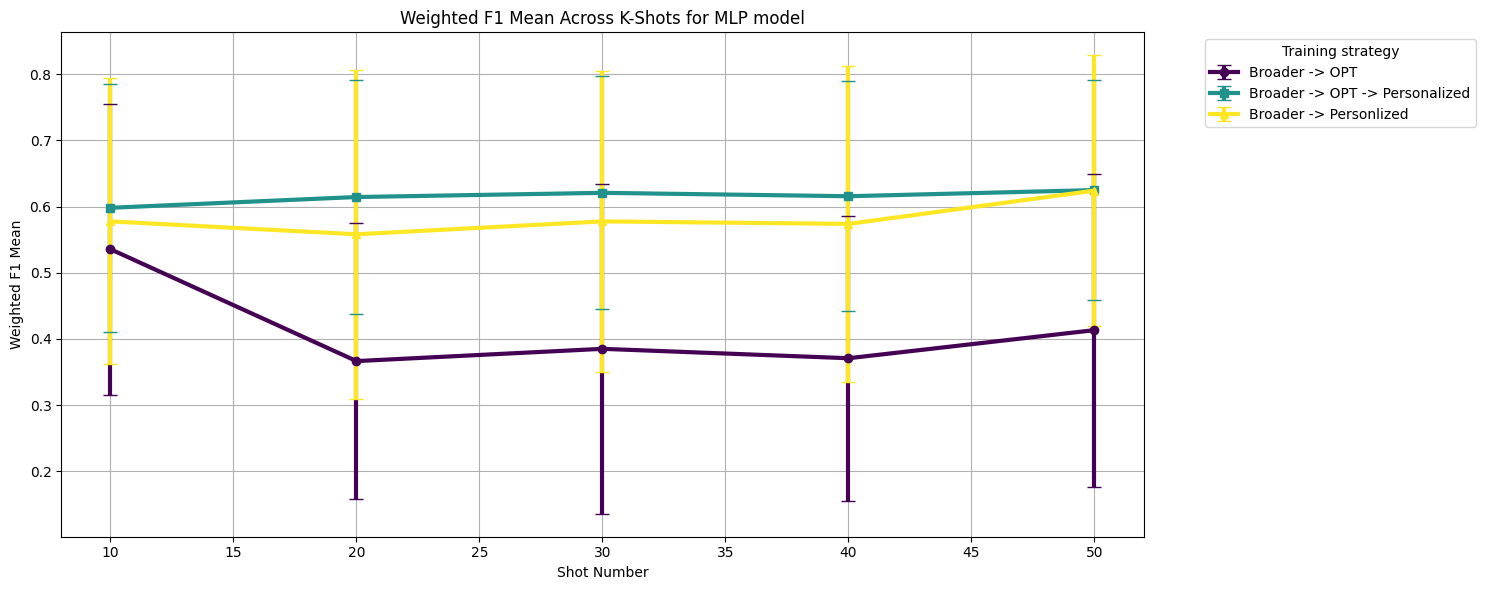

In [17]:
# Import the colormap
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Filter unique conditions
conditions = metric_agg_df['plot_legend'].unique()

# Create a figure
plt.figure(figsize=(15, 6))

# Normalize the number of conditions for the colormap
norm = Normalize(vmin=0, vmax=len(conditions) - 1)
markers = ['o', 's', '^', 'D', 'v', 'x']
# Loop through each condition and plot the data
for idx, condition in enumerate(conditions):
    condition_data = metric_agg_df[metric_agg_df['plot_legend'] == condition]
    plt.errorbar(
        condition_data['shot_number'], 
        condition_data['f1_weighted_mean'], 
        yerr=condition_data['f1_weighted_std'], 
        label=condition, 
        capsize=5, 
        marker=markers[idx % len(markers)], 
        color=viridis(norm(idx)),
        linewidth=3
    )

# Add labels, title, and legend
plt.xlabel('Shot Number')
plt.ylabel('Weighted F1 Mean')
plt.title(f"Weighted F1 Mean Across K-Shots for {selected_model} model")
plt.legend(title='Training strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

                      plot_legend
0  Broader -> OPT -> Personalized
1          Broader -> Personlized
2                  Broader -> OPT


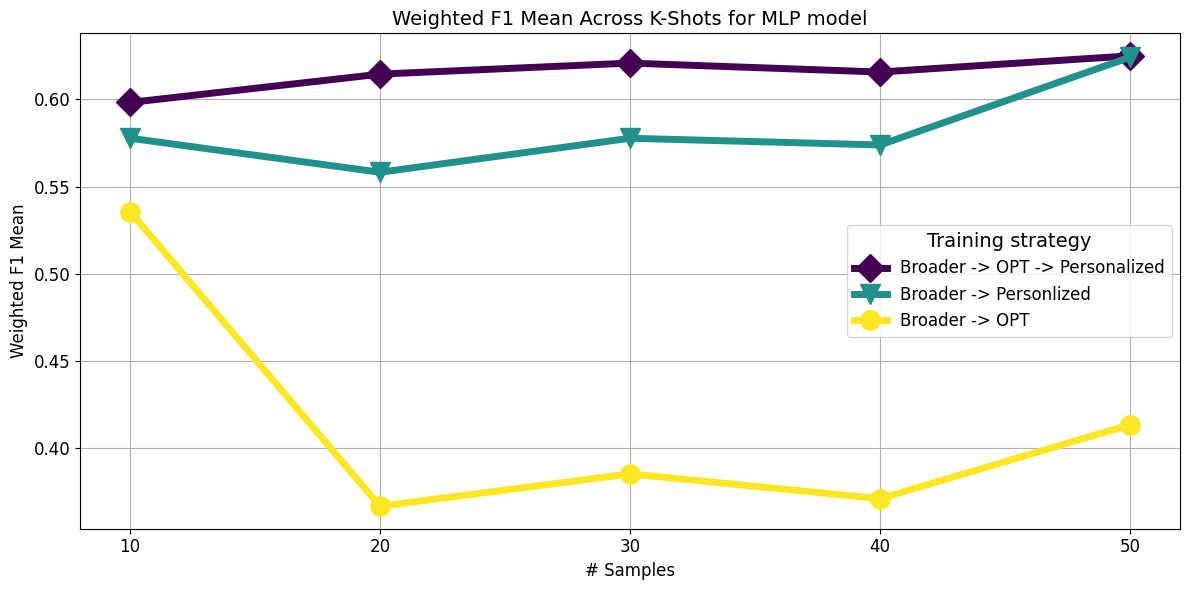

In [30]:
import matplotlib.pyplot as plt
from matplotlib.cm import viridis
from matplotlib.colors import Normalize

# Filter unique conditions
conditions = metric_agg_df['plot_legend'].unique()
#sort conditions based on the f1_weighted_mean of the last shot
print(metric_agg_df[metric_agg_df['shot_number'] == metric_agg_df['shot_number'].max()].sort_values('f1_weighted_mean', ascending=False)[['plot_legend']].reset_index(drop=True))
conditions = metric_agg_df[metric_agg_df['shot_number'] == metric_agg_df['shot_number'].max()].sort_values('f1_weighted_mean', ascending=False)['plot_legend'].tolist()
plt.figure(figsize=(12, 6))

# Normalize for color mapping
norm = Normalize(vmin=0, vmax=len(conditions) - 1)
markers = ['D', 'v', 'o', 's', '^','x']

# Plot each condition
for idx, condition in enumerate(conditions):
    condition_data = metric_agg_df[metric_agg_df['plot_legend'] == condition]
    x = condition_data['shot_number']
    y = condition_data['f1_weighted_mean']
    std = condition_data['f1_weighted_std']
    color = viridis(norm(idx))

    # Main line
    plt.plot(
        x, y,
        marker=markers[idx % len(markers)],
        markersize=14,
        label=condition,
        color=color,
        linewidth=5
    )

    # # Shaded area
    # plt.fill_between(
    #     x,
    #     y - std,
    #     y + std,
    #     color=color,
    #     alpha=0.3
    # )

# Labels, title, legend, and layout
plt.xticks(ticks=list(range(10,60,10)), labels=list(range(10,60,10)))
plt.xlabel('# Samples',fontsize=12)
plt.ylabel('Weighted F1 Mean', fontsize=12)
plt.title(f"Weighted F1 Mean Across K-Shots for {selected_model} model", fontsize=14)
plt.legend(title='Training strategy', loc='right',fontsize=12, title_fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
import re
def individual_results(df_r, metric, results_dir):
    """
    Aggregate the results by calculating the mean and standard deviation of the given metrics.
    """
    print("Aggregating results...")
    # Create an empty DataFrame to store the aggregated results
    df_all_individual = pd.DataFrame()
    for condition in df_r["plot_legend"].unique():
        print(condition)
        # Get the paths and splits for the current condition
        paths = df_r[df_r["plot_legend"] == condition][["path","split"]].values
        # Iterate through each path and split
        for path,split in paths:
            full_path = os.path.join(results_dir, path)
            # Find the longest file name with csv extension
            result_file = max((file for file in os.listdir(full_path) if file.endswith(".csv")), key=len, default="")
            print(split,":", os.path.join(full_path,result_file))
            # Read the csv file
            df = pd.read_csv(os.path.join(full_path,result_file))
            print(df.columns)
            df_individual = df[[metric]].copy()
            fold_participant = pd.Series([f'P{i}' for i in range(1, 14)], index=df_individual.index)
            fold_participant = fold_participant.sort_values().reset_index(drop=True)

            df_individual["fold"] = fold_participant
            
            df_individual["plot_legend"] = condition
            df_individual["split"] = split
            # Extract numbers from the split string using regex
            shot_number = re.search(r'\d+', split)
            df_individual["shot_number"] = int(shot_number.group()) if shot_number else None
            # df_agg["shot"] = split
            df_individual["path"] = path
            df_individual.reset_index(drop=True, inplace=True)
            df_all_individual = pd.concat([df_all_individual, df_individual], axis=0)
    return df_all_individual
df_all_individual = individual_results(results, 'f1_weighted', "/home/hossein/ssl-wearables/data/reports")

Aggregating results...
Broader -> OPT
LOSO 10-shot : /home/hossein/ssl-wearables/data/reports/2025-04-15_21-52/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 20-shot : /home/hossein/ssl-wearables/data/reports/2025-04-15_23-51/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 30-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_00-23/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 40-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16_00-37/mymove_10s_5c_v2_mlp_-1.csv
Index(['cohen_kappa', 'precision', 'recall', 'f1', 'f1_weighted',
       'confusion_matrix', 'auc'],
      dtype='object')
LOSO 50-shot : /home/hossein/ssl-wearables/data/reports/2025-04-16

Plotting individual results...


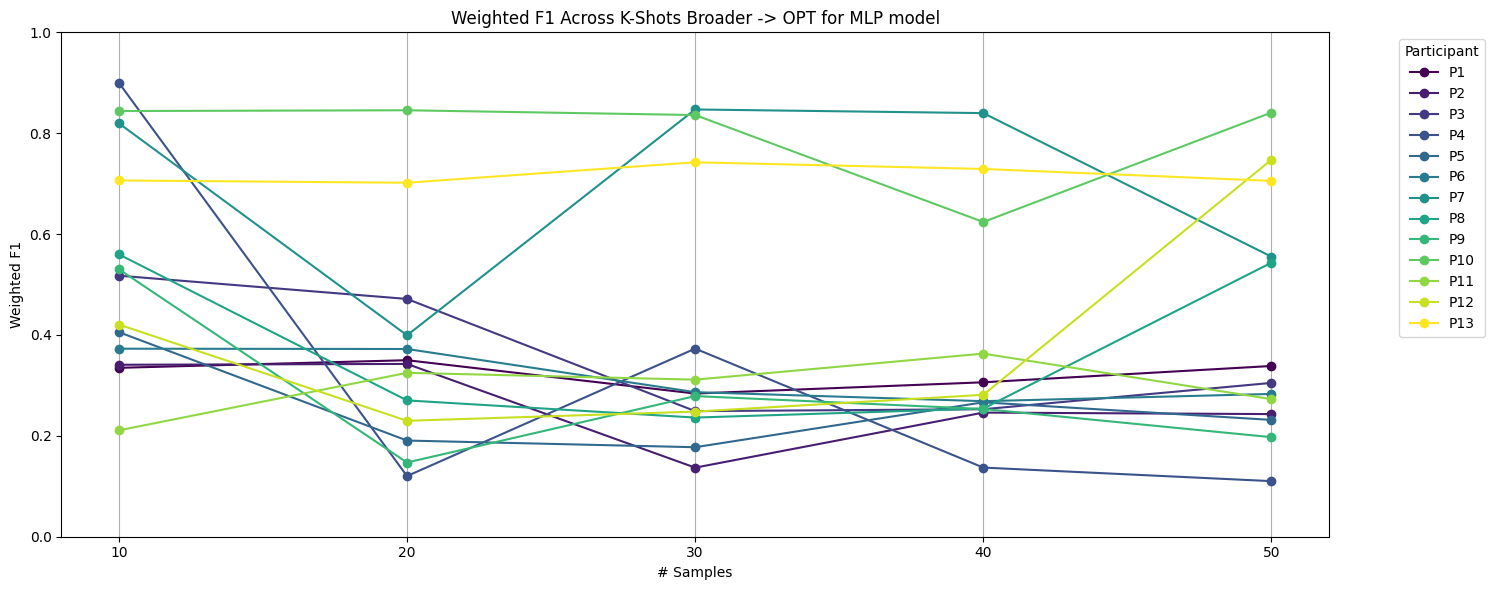

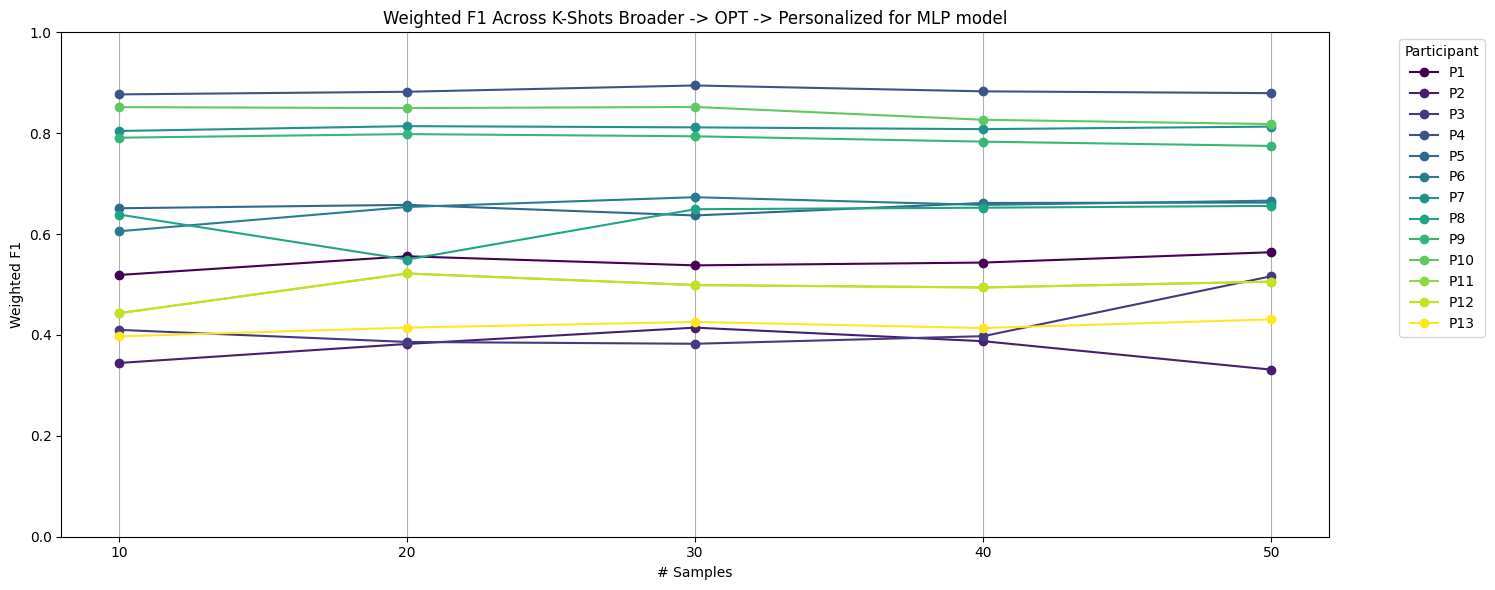

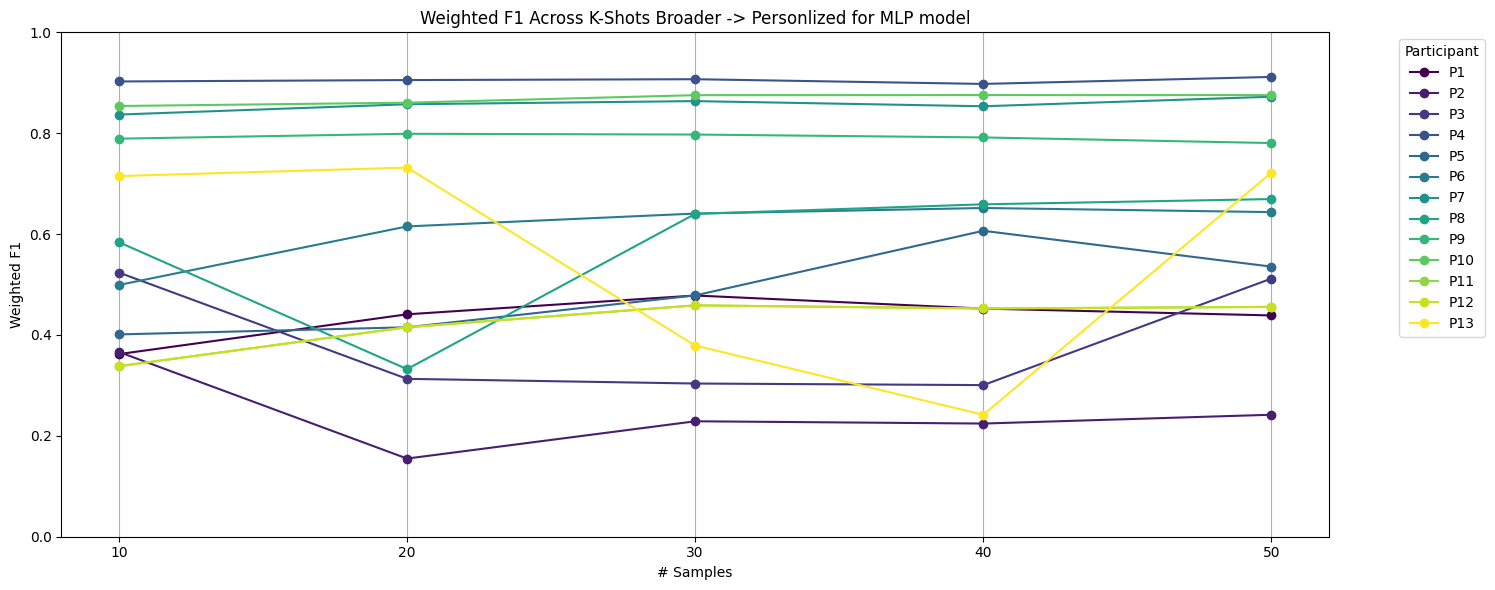

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_results(df, metric):
    """
    Plot the individual results for each condition using the viridis colormap.
    """
    print("Plotting individual results...")

    conditions = df['plot_legend'].unique()
    
    for condition in conditions:
        plt.figure(figsize=(15, 6))
        condition_data = df[df['plot_legend'] == condition]

        # Sort folds numerically based on the number after 'P'
        unique_folds = sorted(
            condition_data['fold'].unique(),
            key=lambda x: int(x.replace('P', ''))
        )

        num_folds = len(unique_folds)
        colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

        for i, fold in enumerate(unique_folds):
            fold_data = condition_data[condition_data['fold'] == fold]
            
            plt.plot(
                fold_data['shot_number'], 
                fold_data[metric], 
                label=f"{fold}", 
                marker='o',
                color=colors[i]
            )

        plt.xlabel('# Samples')
        plt.ylabel('Weighted F1')
        plt.title(f'Weighted F1 Across K-Shots {condition} for {selected_model} model')
        plt.ylim(0, 1)
        plt.xticks(ticks=[10, 20, 30, 40, 50])
        plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, which='major', axis='x')
        plt.xticks(ticks=[10, 20, 30, 40, 50])
        plt.tight_layout()
        plt.show()

# Call the function
plot_individual_results(df_all_individual, 'f1_weighted')

Plotting individual results...


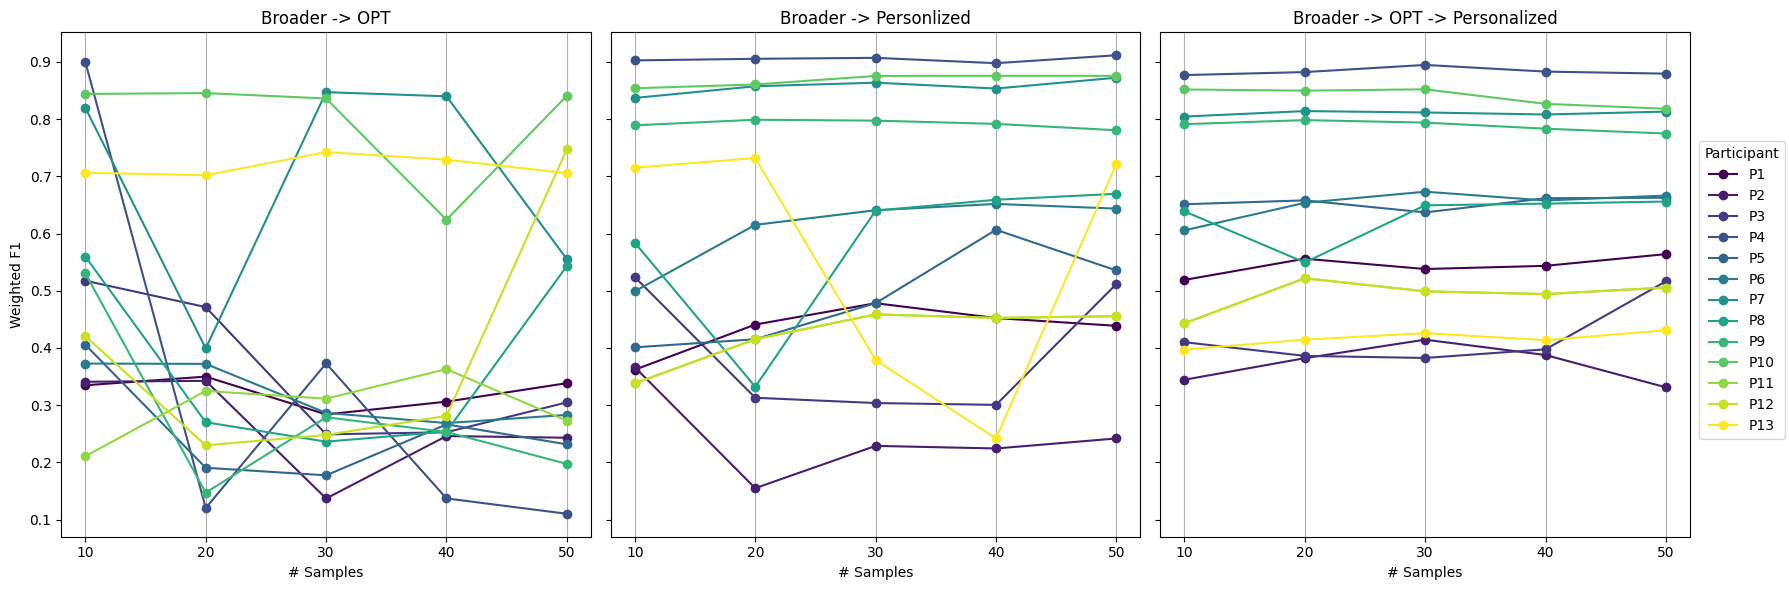

In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_individual_results(df, metric):
    """
    Plot the individual results for each condition using the viridis colormap
    with subplots arranged side by side.
    """
    print("Plotting individual results...")

    conditions = df['plot_legend'].unique()
    num_conditions = len(conditions)
    conditions = sorted(conditions, key=len)
    # Create subplots
    fig, axes = plt.subplots(1, num_conditions, figsize=(6 * num_conditions, 6), sharey=True)

    # If only 1 condition, axes won't be an array
    if num_conditions == 1:
        axes = [axes]

    for ax, condition in zip(axes, conditions):
        condition_data = df[df['plot_legend'] == condition]

        # Sort folds numerically
        unique_folds = sorted(
            condition_data['fold'].unique(),
            key=lambda x: int(x.replace('P', ''))
        )

        num_folds = len(unique_folds)
        colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

        for i, fold in enumerate(unique_folds):
            fold_data = condition_data[condition_data['fold'] == fold]

            ax.plot(
                fold_data['shot_number'], 
                fold_data[metric], 
                label=f"{fold}", 
                marker='o',
                color=colors[i]
            )

        ax.set_xlabel('# Samples')
        ax.set_title(f'{condition}')
        ax.grid(True, which='major', axis='x')
        ax.set_xticks([10, 20, 30, 40, 50])

    # Shared y-axis label
    axes[0].set_ylabel('Weighted F1')

    # Place one shared legend outside the plot
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Participant', bbox_to_anchor=(0.94, 0.5), loc='center left')

    plt.tight_layout(rect=[0, 0, 0.95, 1])  # leave space for legend
    plt.show()

# Call the function
plot_individual_results(df_all_individual, 'f1_weighted')

Plotting f1_weighted at Shot Number 50...


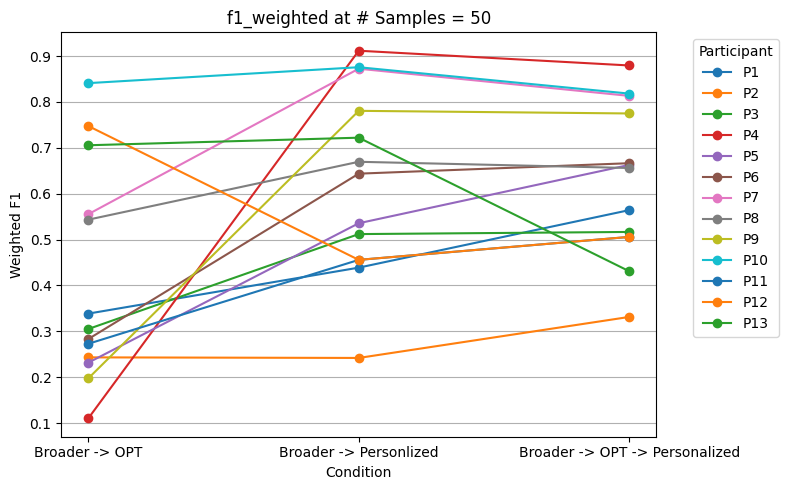

In [28]:
import matplotlib.pyplot as plt
import numpy as np

def plot_results_at_shot(df, metric, shot_number=50):
    """
    Plot results for each condition at a specific shot number.
    X-axis: Condition
    Y-axis: Metric value
    Each line represents a participant (fold).
    """
    print(f"Plotting {metric} at Shot Number {shot_number}...")

    # Filter only the selected shot number
    filtered_df = df[df['shot_number'] == shot_number]

    # Sort conditions alphabetically
    conditions = sorted(filtered_df['plot_legend'].unique())
    conditions = sorted(conditions, key=len)
    # Create a map for conditions to x-axis positions
    condition_to_x = {cond: i for i, cond in enumerate(conditions)}

    # Get all folds and sort numerically
    all_folds = sorted(
        filtered_df['fold'].unique(),
        key=lambda x: int(x.replace('P', ''))
    )

    num_folds = len(all_folds)
    colors = plt.cm.viridis(np.linspace(0, 1, num_folds))

    plt.figure(figsize=(8, 5))

    for i, fold in enumerate(all_folds):
        fold_data = filtered_df[filtered_df['fold'] == fold]

        # Ensure data is ordered by conditions
        fold_data = fold_data.set_index('plot_legend').reindex(conditions)

        y_values = fold_data[metric].values
        x_values = [condition_to_x[cond] for cond in conditions]

        plt.plot(
            x_values,
            y_values,
            marker='o',
            label=fold,
            # color=colors[i]
        )

    plt.xticks(ticks=range(len(conditions)), labels=conditions)
    plt.xlabel('Condition')
    plt.ylabel('Weighted F1')
    plt.title(f'{metric} at # Samples = {shot_number}')
    
    plt.legend(title='Participant', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Call the function
plot_results_at_shot(df_all_individual, 'f1_weighted', shot_number=50)

In [29]:
import pandas as pd

def compare_conditions(df, metric, shot_number=50):
    """
    Compare metric values for two conditions at a specific shot number.
    Outputs a LaTeX table with bolded positive changes.
    """
    print(f"Comparing {metric} at Shot Number {shot_number}...")

    target_conditions = ['Broader -> OPT', 'Broader -> OPT -> Personalized']

    # Filter to shot_number and relevant conditions
    filtered_df = df[
        (df['shot_number'] == shot_number) &
        (df['plot_legend'].isin(target_conditions))
    ]

    # Pivot table: index=fold, columns=condition, values=metric
    pivot = filtered_df.pivot(index='fold', columns='plot_legend', values=metric)

    # Drop incomplete rows
    pivot = pivot.dropna()

    # Compute the change
    pivot['Change'] = pivot['Broader -> OPT -> Personalized'] - pivot['Broader -> OPT']

    # Sort participants numerically
    pivot = pivot.reindex(
        sorted(pivot.index, key=lambda x: int(x.replace('P', '')))
    )

    # Build table with LaTeX bold formatting for positive changes
    table_rows = []
    for fold in pivot.index:
        opt_value = pivot.loc[fold, 'Broader -> OPT']
        personalized_value = pivot.loc[fold, 'Broader -> OPT -> Personalized']
        change = pivot.loc[fold, 'Change']

        # Bold positive changes
        change_str = f"\\textbf{{{change:.3f}}}" if change > 0 else f"{change:.3f}"

        table_rows.append({
            'Participant': fold,
            'Broader -> OPT': f"{opt_value:.3f}",
            'Broader -> OPT -> Personalized': f"{personalized_value:.3f}",
            'Change': change_str
        })

    result_table = pd.DataFrame(table_rows)

    # Generate LaTeX table
    latex_table = result_table.to_latex(index=False, escape=False)
    print(latex_table)

# Example call
compare_conditions(df_all_individual, 'f1_weighted', shot_number=50)

Comparing f1_weighted at Shot Number 50...
\begin{tabular}{llll}
\toprule
Participant & Broader -> OPT & Broader -> OPT -> Personalized &         Change \\
\midrule
         P1 &          0.338 &                          0.564 & \textbf{0.226} \\
         P2 &          0.243 &                          0.331 & \textbf{0.088} \\
         P3 &          0.305 &                          0.517 & \textbf{0.212} \\
         P4 &          0.110 &                          0.879 & \textbf{0.769} \\
         P5 &          0.232 &                          0.663 & \textbf{0.431} \\
         P6 &          0.283 &                          0.666 & \textbf{0.383} \\
         P7 &          0.555 &                          0.813 & \textbf{0.258} \\
         P8 &          0.543 &                          0.656 & \textbf{0.113} \\
         P9 &          0.197 &                          0.775 & \textbf{0.577} \\
        P10 &          0.841 &                          0.818 &         -0.023 \\
        P11 &  

Comparing f1_weighted at Shot Number 50...
|    | Participant   |   Broader -> OPT |   Broader -> OPT -> Personalized | Change    |
|----|---------------|------------------|----------------------------------|-----------|
|  0 | P1            |            0.505 |                            0.42  | -0.084    |
|  1 | P2            |            0.421 |                            0.396 | -0.024    |
|  2 | P3            |            0.39  |                            0.462 | **0.072** |
|  3 | P4            |            0.519 |                            0.704 | **0.185** |
|  4 | P5            |            0.514 |                            0.615 | **0.101** |
|  5 | P6            |            0.394 |                            0.603 | **0.209** |
|  6 | P7            |            0.657 |                            0.725 | **0.069** |
|  7 | P8            |            0.432 |                            0.297 | -0.135    |
|  8 | P9            |            0.505 |                            0.64  | **0.135** |
|  9 | P10           |            0.354 |                            0.697 | **0.343** |
| 10 | P11           |            0.454 |                            0.414 | -0.040    |
| 11 | P12           |            0.678 |                            0.414 | -0.264    |
| 12 | P13           |            0.173 |                            0.563 | **0.391** |